# [GD] Project: CAM, Grad-CAM을 만들어보고 평가해보자

## 라이브러리 확인하기

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(Image.__version__)

2.9.1
1.23.2
4.6.0
9.0.1


* GPU 작동 확인

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data EDA

### Dataset 다운로드

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

2022-10-24 23:44:00.050765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 23:44:00.563004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6668 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


* tensorflow dataset에 있는 stanford_dogs를 사용해볼 것 입니다.
* train과 test로 나누어서 사용합니다.
* file을 shuffle 해보고 info 정보 또한 가져옵니다.

### 데이터 정보 확인하기

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

* image : 이미지 배열입니다. 크기는 제각각 다른 것 같고 값들의 형태는 int 형태이므로 0 ~ 255의 범위를 가질 것 같습니다.
* image/filename : 텍스트 형태의 파일이름입니다.
* label : ClassLabel입니다. 숫자형태로 되어있으며 총 120개 입니다. 데이터의 이름이 stanford_dogs니 개의 종류를 숫자로 표현한 것 같습니다.
* objects : 시퀀스 형태(dict)의 자료로 해당 데이터에는 bbox만 있습니다.
* 여러 용도에 따라 필요한 것들이 다르기 때문에 다른 데이터에는 objects에 다른 것들이 들어가 있을 수 있습니다.

### 하나의 샘플 가져오는 함수

* 하나의 이미지만 가져오는 함수를 만들어 봅시다.

In [5]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

### 하나의 이미지에 대한 데이터 확인하기

In [6]:
sample = get_one(ds_train)
print(type(sample))
print(sample.keys())

<class 'dict'>
dict_keys(['image', 'image/filename', 'label', 'objects'])


* Dict 형태로 되어있고
* 이미지, 파일 이름, 라벨, bounding box로 되어있습니다.

(500, 481, 3)


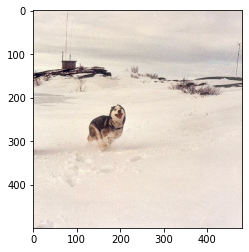

In [7]:
print(sample['image'].shape)
plt.imshow(sample['image'])

In [8]:
print('filename =', sample['image/filename'])
print('label =',sample['label'])
print('objects =',sample['objects'])
sample_bbox = sample['objects']['bbox']
print(sample_bbox.shape)
sample_bbox

filename = b'Images/n02110185-Siberian_husky/n02110185_1532.jpg'
label = 99
objects = {'bbox': array([[0.428     , 0.25363827, 0.65      , 0.44490644]], dtype=float32)}
(1, 4)


array([[0.428     , 0.25363827, 0.65      , 0.44490644]], dtype=float32)

* label은 숫자로 되어있습니다.
* object는 bounding box를 가지는 dict 형태이며 bounding box를 (1, 4)의 형태입니다.
* 2차원 배열로 만들어서 넣어준 이유는 하나의 image에 여러개의 bounding box가 들어갈 수 있기 때문입니다.
* 이미지에 대한 전처리를 해주는 함수를 만들어줍니다.
* size를 [224, 224]로 해줍니다.
* int 값 0 ~ 255에서 float 값으로 바꿔주고 값 범위 또한 0 ~ 1.0 으로 해줍니다.
* 최종적으로 반환하는 image, label 과 bounding box를 가지는 object dict입니다.

## CAM 모델 구현하기

### 전처리 함수 구현

* 여러 크기로 되어있는 데이터를 동일한 크기인 [224, 224]로 만들고
* 0 ~ 255인 int 형태의 값을 0 ~ 1.0의 float 형태로 바꾸고
* 반환은 이미지 배열, label입니다.

In [9]:
def normalize_and_resize_img(input):
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

* 위의 전처리 함수를 dataset에 적용하는 함수를 구현합니다.(LMS 참고)
* ds.repeat()의 명확한 이유는 모르겠으나 넣었을 때 더 성능이 좋다는 것을 확인하였기 때문에 넣어줍니다.

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### Backbone Network 설정

* Backbone Network로 EfficientNetB5를 사용해보겠습니다.
* 마지막 fully connected layer를 제외
* imagenet으로 훈련
* input_shape = (224, 224, 3)
* pooling은 일단 avg로 두었습니다.
* 최종 출력은 softmax를 가진 dense layer를 통과합니다.

In [11]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.efficientnet.EfficientNetB5(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg', 
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [12]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

### 데이터셋에 전처리하기

In [13]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train, batch_size=4)
ds_test_norm = apply_normalize_on_dataset(ds_test, batch_size=4)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(4, 224, 224, 3)
(4,)


### 모델 학습하기

In [14]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

* Epcoh는 15로 잡겠습니다.

In [15]:
EPOCH = 15

# history_cam_model = cam_model.fit(
#     ds_train_norm,
#     # steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     # validation_steps=int(ds_info.splits['test'].num_examples/16),
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/4),
#     validation_steps=int(ds_info.splits['test'].num_examples/4),
#     epochs=EPOCH,
#     validation_data=ds_test_norm,
#     verbose=1,
#     use_multiprocessing=True,
# )

* 학습시킨 가중치를 저장하겠습니다.

In [16]:
# cam_model_path = '/home/aiffel/Code/Going_Deeper/Going_Deeper_Project/5/data/cam_model_mine.h5'
# cam_model.save(cam_model_path)
# print("저장 완료!")

* 학습 시간이 너무 오래 걸려서 저장되어있는 가중치를 사용하겠습니다.

In [17]:
cam_model_path = '/home/aiffel/Code/Going_Deeper/Going_Deeper_Project/5/data/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

### CAM 모델을 생성하는 함수

In [18]:
def generate_cam(model, item):
    cam_image = None
    # data의 copy해서 사용합니다.
    item = copy.deepcopy(item)
    # data의 너비와 높이를 저장합니다.
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx= normalize_and_resize_img(item)
    
    # model.layers[-3].output에서 avg_pool 이전의 top_activation이 저희가 원하는 feature map입니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer(softmax를 가진 dense)에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]
        
    # activation score를 normalize합니다. 0 ~ 1.0
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

### CAM 이미지 생성

* 이미지 하나를 test set에서 불러와 봅시다.

(332, 500, 3)


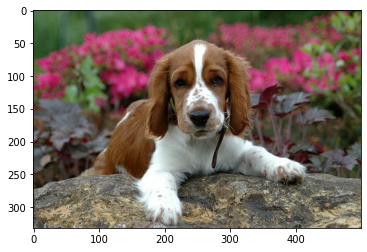

In [19]:
item = get_one(ds_test)
image = item['image']
print(image.shape)
plt.imshow(image)
plt.show()

* 이제 CAM 이미지를 생성해봅시다.

2022-10-24 23:44:09.743447: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


(332, 500)


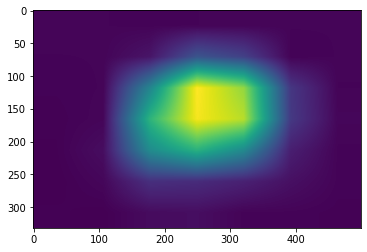

In [20]:
cam_image = generate_cam(cam_model, item)
print(cam_image.shape)
plt.imshow(cam_image)
plt.show()

### 원본과 CAM 이미지를 겹쳐 보여주는 함수

* 서로 반반씩 섞어주는 함수를 구현합니다.

In [21]:
def visualize_cam_on_image(image, cam_image):
    merged_image = None
    merged_image = cv2.addWeighted(image, 0.5, cam_image, 0.5, 0.0)
    return merged_image

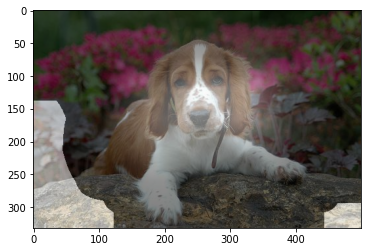

In [22]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM 구현하기

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # GAP의 역할을 수행한다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

* 여러 레이어에 따라 CAM 이미지를 출력해봅시다.

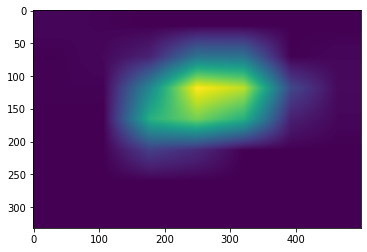

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

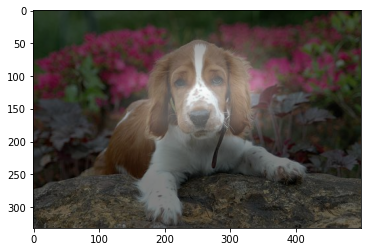

In [25]:
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

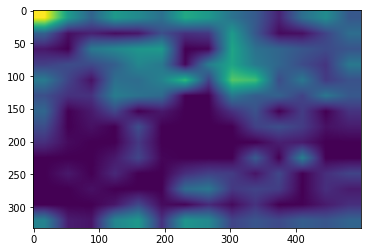

In [26]:
grad_cam_image_2 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image_2)
plt.show()

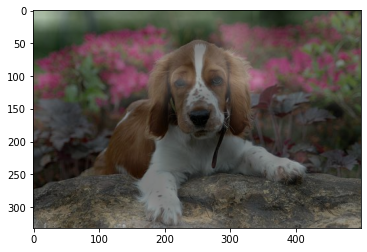

In [27]:
cam_image_3channel = np.stack([grad_cam_image_2*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

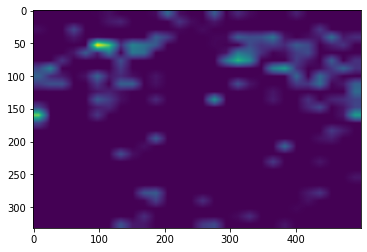

In [28]:
grad_cam_image_3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image_3)
plt.show()

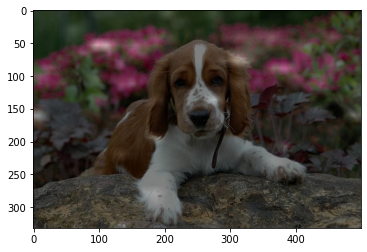

In [29]:
cam_image_3channel = np.stack([grad_cam_image_3*255]*3, axis=-1).astype(np.uint8)
blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## 바운딩 박스 구하기

* 바운딩 박스를 구하는 함수입니다.(좌표로 변환해 줍니다.)

In [30]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

* 기존 이미지에 CAM으로 만든 바운딩 박스를 그려봅시다.

In [31]:
rect = get_bbox(cam_image)
rect

array([[111,  33],
       [443,  33],
       [443, 294],
       [111, 294]])

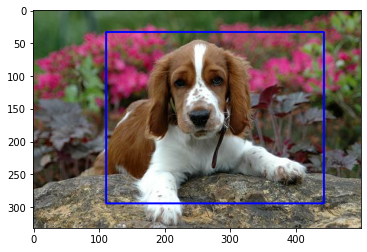

In [32]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

* 기존 이미지에 Grad-CAM으로 만든 바운딩 박스를 그려봅시다.

In [33]:
rect_2 = get_bbox(grad_cam_image)
rect_2

array([[ 79,  72],
       [409, -27],
       [471, 172],
       [140, 273]])

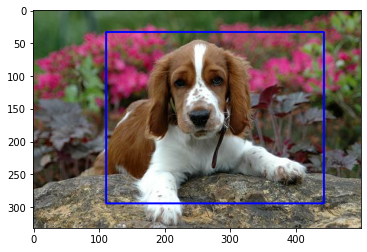

In [34]:
image_2 = copy.deepcopy(item['image'])
image_2 = cv2.drawContours(image_2, [rect_2], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

## IoU 구하기

* IoU를 구하는 함수를 구현합니다.

In [35]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

* 기존의 CAM또는 Grad-CAM에서 구한 bounding box인 rect의 값은 좌표 이므로
* Data의 bounding box와 같게 비율로 바꿔줍니다.

In [36]:
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [37]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox_2 = rect_to_minmax(rect_2, item['image'])

* 구한 값들을 통해 IoU를 값을 구해봅시다.

In [39]:
print(get_iou(pred_bbox, item['objects']['bbox'][0]))
get_iou(pred_bbox_2, item['objects']['bbox'][0])

0.6983858334151163


0.553156846572964

### 회고

* 이번 프로젝트에서 어려웠던 점
    - 코드 내용을 도움 하나도 없이 구현하는건 거의 불가능하였습니다.
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된점
    - IoU가 Grad-CAM 보다 일반 CAM이 더 높게 나올 수 있습니다.
  * 아직 모호한 점
    - CAM과 Grad-CAM의 세부적인 코드 구성
* 루브릭 평가를 맞추기 위해 시도한 점
    - CAM, Grad-CAM 각각에 맞게 이미지를 출력하였습니다.